In [1]:
# imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import glob
import os
import h5_utilities_module as h5u
from tqdm import tqdm as tqdm
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [2]:
#functions
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            
            if np.sum(nan_mask[:, col]) > 0:
                bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
                bootstrap_means[:, col] = np.nanmean(bootstrap_samples, axis=1)
            else:
                bootstrap_means[:, col] = np.nan

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.nanmean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.nanmean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val

In [3]:
# where are the data?
data_dir = 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/decoder_output/'

# get their relevant paths
data_files = h5u.find_h5_files(data_dir)

In [4]:
# initialize lists to accumulate data into
OFC_ch = []
OFC_unch = []
OFC_alt_ch = []
OFC_alt_unch = []
CdN_ch = []
CdN_unch = []
CdN_alt_ch = []
CdN_alt_unch = []
bhv = pd.DataFrame()
OFC_acc = []
CdN_acc = []
subject = []
session = []
OFC_cue_pp = []


# accumulate data from each file

for f_num, this_file in enumerate(data_files):
    
    if 'D' in Path(this_file).stem:
        s = 0
    else:
        s = 1
            
    # Append the data to the lists
    subject.append(np.ones(len(h5u.pull_from_h5(this_file, 'OFC_acc_mean')), )*s)
    session.append(np.ones(len(h5u.pull_from_h5(this_file, 'OFC_acc_mean')), )*f_num)

    bhv = pd.concat([bhv, pd.read_hdf(this_file, key='bhv')], ignore_index=True)
    
    OFC_ch.append(h5u.pull_from_h5(this_file, 'OFC_ch'))
    OFC_unch.append(h5u.pull_from_h5(this_file, 'OFC_unch'))
    OFC_alt_ch.append(h5u.pull_from_h5(this_file, 'OFC_alt_ch'))
    OFC_alt_unch.append(h5u.pull_from_h5(this_file, 'OFC_alt_unch'))
    
    CdN_ch.append(h5u.pull_from_h5(this_file, 'CdN_ch'))
    CdN_unch.append(h5u.pull_from_h5(this_file, 'CdN_unch'))
    CdN_alt_ch.append(h5u.pull_from_h5(this_file, 'CdN_alt_ch'))
    CdN_alt_unch.append(h5u.pull_from_h5(this_file, 'CdN_alt_unch'))
    
    OFC_acc.append(h5u.pull_from_h5(this_file, 'OFC_acc_mean'))
    CdN_acc.append(h5u.pull_from_h5(this_file, 'CdN_acc_mean'))
    
    ts = h5u.pull_from_h5(this_file, 'ts')
    
    
# convert everything back to arrays
subject = np.concatenate(subject, axis=0)
session = np.concatenate(session, axis=0)

OFC_ch = np.concatenate(OFC_ch, axis=0)
OFC_unch = np.concatenate(OFC_unch, axis=0)
OFC_alt_ch = np.concatenate(OFC_alt_ch, axis=0)
OFC_alt_unch = np.concatenate(OFC_alt_unch, axis=0)

CdN_ch = np.concatenate(CdN_ch, axis=0)
CdN_unch = np.concatenate(CdN_unch, axis=0)
CdN_alt_ch = np.concatenate(CdN_alt_ch, axis=0)
CdN_alt_unch = np.concatenate(CdN_alt_unch, axis=0)

OFC_acc = np.concatenate(OFC_acc, axis=0)
CdN_acc = np.concatenate(CdN_acc, axis=0)

In [5]:
# get the labels associated with each unique state-value pair
ch_val, unch_val = get_ch_and_unch_vals(bhv)
s_ch_val = ch_val.copy()
s_unch_val = unch_val.copy()

s_ch_val[bhv['state'] == 2] = s_ch_val[bhv['state'] == 2] + 4
s_ch_val[bhv['state'] == 3] = s_ch_val[bhv['state'] == 3] + 8
s_unch_val[bhv['state'] == 2] = s_unch_val[bhv['state'] == 2] + 4
s_unch_val[bhv['state'] == 3] = s_unch_val[bhv['state'] == 3] + 8

In [6]:
# align posteriors to saccades

# set some parameters
n_trials = len(bhv)
ts_offset = [12, 13] # each sample is 25 ms long, so, 12 samples = 300 ms

# initialize lists to accumulate data into

# arrays are organized along 3rd dim as: ch_val, unch_val, alt_ch, alt_unch
first_sacc_ofc_pps = np.full((n_trials, np.sum(ts_offset), 4), np.nan)
first_sacc_cdn_pps = np.full((n_trials, np.sum(ts_offset), 4), np.nan)
second_sacc_ofc_pps = np.full((n_trials, np.sum(ts_offset), 4), np.nan)
second_sacc_cdn_pps = np.full((n_trials, np.sum(ts_offset), 4), np.nan)

# loop over individual trials
for t in tqdm(range(n_trials)):

    # first, only analyze the first saccade

    if bhv['n_sacc'].iloc[t] > 0:

        # get index of the first saccade on this trial
        t_sacc1_time_ix = np.argmin(np.abs(bhv['sacc1_t'].iloc[t] - ts))
        t_sacc1_start =  t_sacc1_time_ix - ts_offset[0]
        ts_sacc1_end = t_sacc1_time_ix + ts_offset[1]

        first_sacc_ofc_pps[t,:,0] = OFC_ch[t, t_sacc1_start:ts_sacc1_end]
        first_sacc_ofc_pps[t,:,1] = OFC_unch[t, t_sacc1_start:ts_sacc1_end]
        first_sacc_ofc_pps[t,:,2] = OFC_alt_ch[t, t_sacc1_start:ts_sacc1_end]
        first_sacc_ofc_pps[t,:,3] = OFC_alt_unch[t, t_sacc1_start:ts_sacc1_end]

        first_sacc_cdn_pps[t,:,0] = CdN_ch[t, t_sacc1_start:ts_sacc1_end]
        first_sacc_cdn_pps[t,:,1] = CdN_unch[t, t_sacc1_start:ts_sacc1_end]
        first_sacc_cdn_pps[t,:,2] = CdN_alt_ch[t, t_sacc1_start:ts_sacc1_end]
        first_sacc_cdn_pps[t,:,3] = CdN_alt_unch[t, t_sacc1_start:ts_sacc1_end]

    # now pull out the second saccade of double-saccade trials
    if bhv['n_sacc'].iloc[t] == 2:

        # get index of the first saccade on this trial
        t_sacc2_time_ix = np.argmin(np.abs(bhv['sacc2_t'].iloc[t] - ts))
        ts_sacc2_start =  t_sacc2_time_ix - ts_offset[0]
        ts_sacc2_end = t_sacc2_time_ix + ts_offset[1]

        if ts_sacc2_end < len(ts):

            second_sacc_ofc_pps[t,:,0] = OFC_ch[t, ts_sacc2_start:ts_sacc2_end]
            second_sacc_ofc_pps[t,:,1] = OFC_unch[t, ts_sacc2_start:ts_sacc2_end]
            second_sacc_ofc_pps[t,:,2] = OFC_alt_ch[t, ts_sacc2_start:ts_sacc2_end]
            second_sacc_ofc_pps[t,:,3] = OFC_alt_unch[t, ts_sacc2_start:ts_sacc2_end]

            second_sacc_cdn_pps[t,:,0] = CdN_ch[t, ts_sacc2_start:ts_sacc2_end]
            second_sacc_cdn_pps[t,:,1] = CdN_unch[t, ts_sacc2_start:ts_sacc2_end]
            second_sacc_cdn_pps[t,:,2] = CdN_alt_ch[t, ts_sacc2_start:ts_sacc2_end]
            second_sacc_cdn_pps[t,:,3] = CdN_alt_unch[t, ts_sacc2_start:ts_sacc2_end]


100%|██████████| 8825/8825 [00:00<00:00, 63201.20it/s]


In [7]:
# create indices for the single and double saccade trials
single_ix = bhv['n_sacc'] == 1
double_ix = bhv['n_sacc'] == 2

# create indices for each subject
d_ix = subject == 0
k_ix = subject == 1

# get means and intervals

#----------------------------
# SUBJECT D
# OFC
# first saccade of single saccade trial
d_1sacc_ofc_ch_mean, d_1sacc_ofc_ch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[single_ix & d_ix,:, 0], 'bootstrap')
d_1sacc_ofc_unch_mean, d_1sacc_ofc_unch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[single_ix & d_ix,:, 1], 'bootstrap')
d_1sacc_ofc_alt_ch_mean, d_1sacc_ofc_alt_ch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[single_ix & d_ix,:, 2], 'bootstrap')
d_1sacc_ofc_alt_unch_mean, d_1sacc_ofc_alt_unch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[single_ix & d_ix,:, 3], 'bootstrap')

# first saccade of double saccade trial
d_1sacc2_ofc_ch_mean, d_1sacc2_ofc_ch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[double_ix & d_ix,:, 0], 'bootstrap')
d_1sacc2_ofc_unch_mean, d_1sacc2_ofc_unch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[double_ix & d_ix,:, 1], 'bootstrap')
d_1sacc2_ofc_alt_ch_mean, d_1sacc2_ofc_alt_ch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[double_ix & d_ix,:, 2], 'bootstrap')
d_1sacc2_ofc_alt_unch_mean, d_1sacc2_ofc_alt_unch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[double_ix & d_ix,:, 3], 'bootstrap')

# second saccade of double saccade trial
d_2sacc2_ofc_ch_mean, d_2sacc2_ofc_ch_ci = calculate_mean_and_interval(second_sacc_ofc_pps[double_ix & d_ix,:, 0], 'bootstrap')
d_2sacc2_ofc_unch_mean, d_2sacc2_ofc_unch_ci = calculate_mean_and_interval(second_sacc_ofc_pps[double_ix & d_ix,:, 1], 'bootstrap')
d_2sacc2_ofc_alt_ch_mean, d_2sacc2_ofc_alt_ch_ci = calculate_mean_and_interval(second_sacc_ofc_pps[double_ix & d_ix,:, 2], 'bootstrap')
d_2sacc2_ofc_alt_unch_mean, d_2sacc2_ofc_alt_unch_ci = calculate_mean_and_interval(second_sacc_ofc_pps[double_ix & d_ix,:, 3], 'bootstrap')

# CDN
# first saccade of single saccade trial
d_1sacc_cdn_ch_mean, d_1sacc_cdn_ch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[single_ix & d_ix,:, 0], 'bootstrap')
d_1sacc_cdn_unch_mean, d_1sacc_cdn_unch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[single_ix & d_ix,:, 1], 'bootstrap')
d_1sacc_cdn_alt_ch_mean, d_1sacc_cdn_alt_ch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[single_ix & d_ix,:, 2], 'bootstrap')
d_1sacc_cdn_alt_unch_mean, d_1sacc_cdn_alt_unch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[single_ix & d_ix,:, 3], 'bootstrap')

# first saccade of double saccade trial
d_1sacc2_cdn_ch_mean, d_1sacc2_cdn_ch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[double_ix & d_ix,:, 0], 'bootstrap')
d_1sacc2_cdn_unch_mean, d_1sacc2_cdn_unch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[double_ix & d_ix,:, 1], 'bootstrap')
d_1sacc2_cdn_alt_ch_mean, d_1sacc2_cdn_alt_ch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[double_ix & d_ix,:, 2], 'bootstrap')
d_1sacc2_cdn_alt_unch_mean, d_1sacc2_cdn_alt_unch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[double_ix & d_ix,:, 3], 'bootstrap')

# second saccade of double saccade trial
d_2sacc2_cdn_ch_mean, d_2sacc2_cdn_ch_ci = calculate_mean_and_interval(second_sacc_cdn_pps[double_ix & d_ix,:, 0], 'bootstrap')
d_2sacc2_cdn_unch_mean, d_2sacc2_cdn_unch_ci = calculate_mean_and_interval(second_sacc_cdn_pps[double_ix & d_ix,:, 1], 'bootstrap')
d_2sacc2_cdn_alt_ch_mean, d_2sacc2_cdn_alt_ch_ci = calculate_mean_and_interval(second_sacc_cdn_pps[double_ix & d_ix,:, 2], 'bootstrap')
d_2sacc2_cdn_alt_unch_mean, d_2sacc2_cdn_alt_unch_ci = calculate_mean_and_interval(second_sacc_cdn_pps[double_ix & d_ix,:, 3], 'bootstrap')


#----------------------------
# SUBJECT K
# OFC
# first saccade of single saccade trial
k_1sacc_ofc_ch_mean, k_1sacc_ofc_ch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[single_ix & k_ix,:, 0], 'bootstrap')
k_1sacc_ofc_unch_mean, k_1sacc_ofc_unch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[single_ix & k_ix,:, 1], 'bootstrap')
k_1sacc_ofc_alt_ch_mean, k_1sacc_ofc_alt_ch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[single_ix & k_ix,:, 2], 'bootstrap')
k_1sacc_ofc_alt_unch_mean, k_1sacc_ofc_alt_unch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[single_ix & k_ix,:, 3], 'bootstrap')

# first saccade of double saccade trial
k_1sacc2_ofc_ch_mean, k_1sacc2_ofc_ch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[double_ix & k_ix,:, 0], 'bootstrap')
k_1sacc2_ofc_unch_mean, k_1sacc2_ofc_unch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[double_ix & k_ix,:, 1], 'bootstrap')
k_1sacc2_ofc_alt_ch_mean, k_1sacc2_ofc_alt_ch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[double_ix & k_ix,:, 2], 'bootstrap')
k_1sacc2_ofc_alt_unch_mean, k_1sacc2_ofc_alt_unch_ci = calculate_mean_and_interval(first_sacc_ofc_pps[double_ix & k_ix,:, 3], 'bootstrap')

# second saccade of double saccade trial
k_2sacc2_ofc_ch_mean, k_2sacc2_ofc_ch_ci = calculate_mean_and_interval(second_sacc_ofc_pps[double_ix & k_ix,:, 0], 'bootstrap')
k_2sacc2_ofc_unch_mean, k_2sacc2_ofc_unch_ci = calculate_mean_and_interval(second_sacc_ofc_pps[double_ix & k_ix,:, 1], 'bootstrap')
k_2sacc2_ofc_alt_ch_mean, k_2sacc2_ofc_alt_ch_ci = calculate_mean_and_interval(second_sacc_ofc_pps[double_ix & k_ix,:, 2], 'bootstrap')
k_2sacc2_ofc_alt_unch_mean, k_2sacc2_ofc_alt_unch_ci = calculate_mean_and_interval(second_sacc_ofc_pps[double_ix & k_ix,:, 3], 'bootstrap')

# CDN
# first saccade of single saccade trial
k_1sacc_cdn_ch_mean, k_1sacc_cdn_ch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[single_ix & k_ix,:, 0], 'bootstrap')
k_1sacc_cdn_unch_mean, k_1sacc_cdn_unch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[single_ix & k_ix,:, 1], 'bootstrap')
k_1sacc_cdn_alt_ch_mean, k_1sacc_cdn_alt_ch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[single_ix & k_ix,:, 2], 'bootstrap')
k_1sacc_cdn_alt_unch_mean, k_1sacc_cdn_alt_unch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[single_ix & k_ix,:, 3], 'bootstrap')

# first saccade of double saccade trial
k_1sacc2_cdn_ch_mean, k_1sacc2_cdn_ch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[double_ix & k_ix,:, 0], 'bootstrap')
k_1sacc2_cdn_unch_mean, k_1sacc2_cdn_unch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[double_ix & k_ix,:, 1], 'bootstrap')
k_1sacc2_cdn_alt_ch_mean, k_1sacc2_cdn_alt_ch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[double_ix & k_ix,:, 2], 'bootstrap')
k_1sacc2_cdn_alt_unch_mean, k_1sacc2_cdn_alt_unch_ci = calculate_mean_and_interval(first_sacc_cdn_pps[double_ix & k_ix,:, 3], 'bootstrap')

# second saccade of double saccade trial
k_2sacc2_cdn_ch_mean, k_2sacc2_cdn_ch_ci = calculate_mean_and_interval(second_sacc_cdn_pps[double_ix & k_ix,:, 0], 'bootstrap')
k_2sacc2_cdn_unch_mean, k_2sacc2_cdn_unch_ci = calculate_mean_and_interval(second_sacc_cdn_pps[double_ix & k_ix,:, 1], 'bootstrap')
k_2sacc2_cdn_alt_ch_mean, k_2sacc2_cdn_alt_ch_ci = calculate_mean_and_interval(second_sacc_cdn_pps[double_ix & k_ix,:, 2], 'bootstrap')
k_2sacc2_cdn_alt_unch_mean, k_2sacc2_cdn_alt_unch_ci = calculate_mean_and_interval(second_sacc_cdn_pps[double_ix & k_ix,:, 3], 'bootstrap')

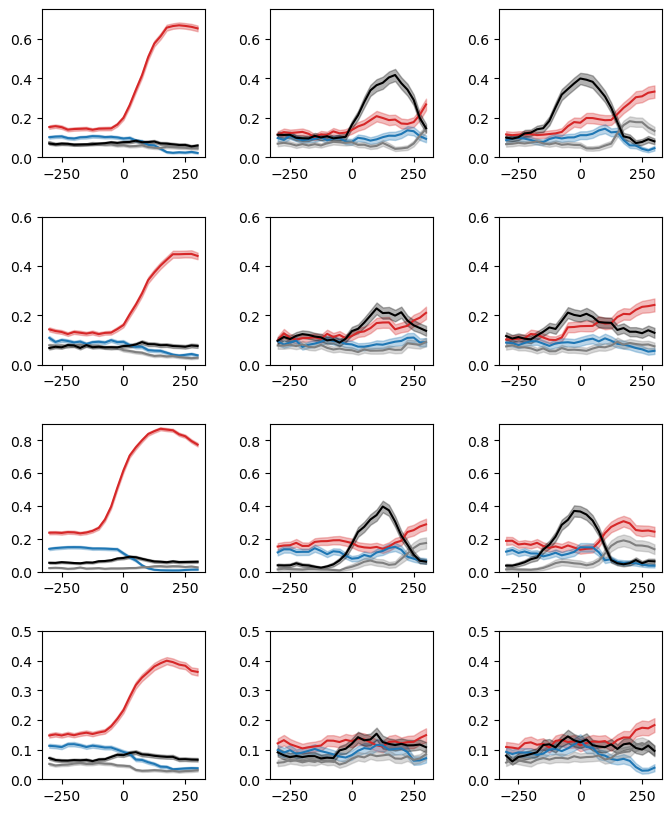

In [ ]:
# do some plotting

# create array for the x-axis
ts_step = np.mean(np.diff(ts))
sacc_ts = np.arange(0, np.sum(ts_offset)*ts_step, ts_step) - ts_offset[0]*ts_step

fig, ax = plt.subplots(4, 3, figsize=(8, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

ch_col = 'tab:red'
unch_col = 'tab:blue'
alt_ch_col = 'tab:gray'
alt_unch_col = 'black'
alpha = .3

# SUBJECT D - OFC

# first saccade of single saccade trial
ax[0,0].fill_between(sacc_ts, d_1sacc_ofc_ch_mean - d_1sacc_ofc_ch_ci, d_1sacc_ofc_ch_mean + d_1sacc_ofc_ch_ci, color=ch_col, alpha=alpha)
ax[0,0].plot(sacc_ts, d_1sacc_ofc_ch_mean, color = ch_col)

ax[0,0].fill_between(sacc_ts, d_1sacc_ofc_unch_mean - d_1sacc_ofc_unch_ci, d_1sacc_ofc_unch_mean + d_1sacc_ofc_unch_ci, color=unch_col, alpha=alpha)
ax[0,0].plot(sacc_ts, d_1sacc_ofc_unch_mean, color = unch_col)

ax[0,0].fill_between(sacc_ts, d_1sacc_ofc_alt_ch_mean - d_1sacc_ofc_alt_ch_ci, d_1sacc_ofc_alt_ch_mean + d_1sacc_ofc_alt_ch_ci, color=alt_ch_col, alpha=alpha)
ax[0,0].plot(sacc_ts, d_1sacc_ofc_alt_ch_mean, color = alt_ch_col)

ax[0,0].fill_between(sacc_ts, d_1sacc_ofc_alt_unch_mean - d_1sacc_ofc_alt_unch_ci, d_1sacc_ofc_alt_unch_mean + d_1sacc_ofc_alt_unch_ci, color=alt_unch_col, alpha=alpha)
ax[0,0].plot(sacc_ts, d_1sacc_ofc_alt_unch_mean, color = alt_unch_col)
ax[0,0].set_ylim((0, .75))

# first saccade of double saccade trial
ax[0,1].fill_between(sacc_ts, d_1sacc2_ofc_ch_mean - d_1sacc2_ofc_ch_ci, d_1sacc2_ofc_ch_mean + d_1sacc2_ofc_ch_ci, color=ch_col, alpha=alpha)
ax[0,1].plot(sacc_ts, d_1sacc2_ofc_ch_mean, color = ch_col)

ax[0,1].fill_between(sacc_ts, d_1sacc2_ofc_unch_mean - d_1sacc2_ofc_unch_ci, d_1sacc2_ofc_unch_mean + d_1sacc2_ofc_unch_ci, color=unch_col, alpha=alpha)
ax[0,1].plot(sacc_ts, d_1sacc2_ofc_unch_mean, color = unch_col)

ax[0,1].fill_between(sacc_ts, d_1sacc2_ofc_alt_ch_mean - d_1sacc2_ofc_alt_ch_ci, d_1sacc2_ofc_alt_ch_mean + d_1sacc2_ofc_alt_ch_ci, color=alt_ch_col, alpha=alpha)
ax[0,1].plot(sacc_ts, d_1sacc2_ofc_alt_ch_mean, color = alt_ch_col)

ax[0,1].fill_between(sacc_ts, d_1sacc2_ofc_alt_unch_mean - d_1sacc2_ofc_alt_unch_ci, d_1sacc2_ofc_alt_unch_mean + d_1sacc2_ofc_alt_unch_ci, color=alt_unch_col, alpha=alpha)
ax[0,1].plot(sacc_ts, d_1sacc2_ofc_alt_unch_mean, color = alt_unch_col)
ax[0,1].set_ylim((0, .75))

# second saccade of double saccade trial
ax[0,2].fill_between(sacc_ts, d_2sacc2_ofc_ch_mean - d_2sacc2_ofc_ch_ci, d_2sacc2_ofc_ch_mean + d_2sacc2_ofc_ch_ci, color=ch_col, alpha=alpha)
ax[0,2].plot(sacc_ts, d_2sacc2_ofc_ch_mean, color = ch_col)

ax[0,2].fill_between(sacc_ts, d_2sacc2_ofc_unch_mean - d_2sacc2_ofc_unch_ci, d_2sacc2_ofc_unch_mean + d_2sacc2_ofc_unch_ci, color=unch_col, alpha=alpha)
ax[0,2].plot(sacc_ts, d_2sacc2_ofc_unch_mean, color = unch_col)

ax[0,2].fill_between(sacc_ts, d_2sacc2_ofc_alt_ch_mean - d_2sacc2_ofc_alt_ch_ci, d_2sacc2_ofc_alt_ch_mean + d_2sacc2_ofc_alt_ch_ci, color=alt_ch_col, alpha=alpha)
ax[0,2].plot(sacc_ts, d_2sacc2_ofc_alt_ch_mean, color = alt_ch_col)

ax[0,2].fill_between(sacc_ts, d_2sacc2_ofc_alt_unch_mean - d_2sacc2_ofc_alt_unch_ci, d_2sacc2_ofc_alt_unch_mean + d_2sacc2_ofc_alt_unch_ci, color=alt_unch_col, alpha=alpha)
ax[0,2].plot(sacc_ts, d_2sacc2_ofc_alt_unch_mean, color = alt_unch_col)
ax[0,2].set_ylim((0, .75))

# SUBJECT D - CDN

# first saccade of single saccade trial
ax[1,0].fill_between(sacc_ts, d_1sacc_cdn_ch_mean - d_1sacc_cdn_ch_ci, d_1sacc_cdn_ch_mean + d_1sacc_cdn_ch_ci, color=ch_col, alpha=alpha)
ax[1,0].plot(sacc_ts, d_1sacc_cdn_ch_mean, color = ch_col)

ax[1,0].fill_between(sacc_ts, d_1sacc_cdn_unch_mean - d_1sacc_cdn_unch_ci, d_1sacc_cdn_unch_mean + d_1sacc_cdn_unch_ci, color=unch_col, alpha=alpha)
ax[1,0].plot(sacc_ts, d_1sacc_cdn_unch_mean, color = unch_col)

ax[1,0].fill_between(sacc_ts, d_1sacc_cdn_alt_ch_mean - d_1sacc_cdn_alt_ch_ci, d_1sacc_cdn_alt_ch_mean + d_1sacc_cdn_alt_ch_ci, color=alt_ch_col, alpha=alpha)
ax[1,0].plot(sacc_ts, d_1sacc_cdn_alt_ch_mean, color = alt_ch_col)

ax[1,0].fill_between(sacc_ts, d_1sacc_cdn_alt_unch_mean - d_1sacc_cdn_alt_unch_ci, d_1sacc_cdn_alt_unch_mean + d_1sacc_cdn_alt_unch_ci, color=alt_unch_col, alpha=alpha)
ax[1,0].plot(sacc_ts, d_1sacc_cdn_alt_unch_mean, color = alt_unch_col)
ax[1,0].set_ylim((0, .6))

# first saccade of double saccade trial
ax[1,1].fill_between(sacc_ts, d_1sacc2_cdn_ch_mean - d_1sacc2_cdn_ch_ci, d_1sacc2_cdn_ch_mean + d_1sacc2_cdn_ch_ci, color=ch_col, alpha=alpha)
ax[1,1].plot(sacc_ts, d_1sacc2_cdn_ch_mean, color = ch_col)

ax[1,1].fill_between(sacc_ts, d_1sacc2_cdn_unch_mean - d_1sacc2_cdn_unch_ci, d_1sacc2_cdn_unch_mean + d_1sacc2_cdn_unch_ci, color=unch_col, alpha=alpha)
ax[1,1].plot(sacc_ts, d_1sacc2_cdn_unch_mean, color = unch_col)

ax[1,1].fill_between(sacc_ts, d_1sacc2_cdn_alt_ch_mean - d_1sacc2_cdn_alt_ch_ci, d_1sacc2_cdn_alt_ch_mean + d_1sacc2_cdn_alt_ch_ci, color=alt_ch_col, alpha=alpha)
ax[1,1].plot(sacc_ts, d_1sacc2_cdn_alt_ch_mean, color = alt_ch_col)

ax[1,1].fill_between(sacc_ts, d_1sacc2_cdn_alt_unch_mean - d_1sacc2_cdn_alt_unch_ci, d_1sacc2_cdn_alt_unch_mean + d_1sacc2_cdn_alt_unch_ci, color=alt_unch_col, alpha=alpha)
ax[1,1].plot(sacc_ts, d_1sacc2_cdn_alt_unch_mean, color = alt_unch_col)
ax[1,1].set_ylim((0, .6))

# second saccade of double saccade trial
ax[1,2].fill_between(sacc_ts, d_2sacc2_cdn_ch_mean - d_2sacc2_cdn_ch_ci, d_2sacc2_cdn_ch_mean + d_2sacc2_cdn_ch_ci, color=ch_col, alpha=alpha)
ax[1,2].plot(sacc_ts, d_2sacc2_cdn_ch_mean, color = ch_col)

ax[1,2].fill_between(sacc_ts, d_2sacc2_cdn_unch_mean - d_2sacc2_cdn_unch_ci, d_2sacc2_cdn_unch_mean + d_2sacc2_cdn_unch_ci, color=unch_col, alpha=alpha)
ax[1,2].plot(sacc_ts, d_2sacc2_cdn_unch_mean, color = unch_col)

ax[1,2].fill_between(sacc_ts, d_2sacc2_cdn_alt_ch_mean - d_2sacc2_cdn_alt_ch_ci, d_2sacc2_cdn_alt_ch_mean + d_2sacc2_cdn_alt_ch_ci, color=alt_ch_col, alpha=alpha)
ax[1,2].plot(sacc_ts, d_2sacc2_cdn_alt_ch_mean, color = alt_ch_col)

ax[1,2].fill_between(sacc_ts, d_2sacc2_cdn_alt_unch_mean - d_2sacc2_cdn_alt_unch_ci, d_2sacc2_cdn_alt_unch_mean + d_2sacc2_cdn_alt_unch_ci, color=alt_unch_col, alpha=alpha)
ax[1,2].plot(sacc_ts, d_2sacc2_cdn_alt_unch_mean, color = alt_unch_col)
ax[1,2].set_ylim((0, .6))

# SUBJECT K - OFC

# first saccade of single saccade trial
ax[2,0].fill_between(sacc_ts, k_1sacc_ofc_ch_mean - k_1sacc_ofc_ch_ci, k_1sacc_ofc_ch_mean + k_1sacc_ofc_ch_ci, color=ch_col, alpha=alpha)
ax[2,0].plot(sacc_ts, k_1sacc_ofc_ch_mean, color = ch_col)

ax[2,0].fill_between(sacc_ts, k_1sacc_ofc_unch_mean - k_1sacc_ofc_unch_ci, k_1sacc_ofc_unch_mean + k_1sacc_ofc_unch_ci, color=unch_col, alpha=alpha)
ax[2,0].plot(sacc_ts, k_1sacc_ofc_unch_mean, color = unch_col)

ax[2,0].fill_between(sacc_ts, k_1sacc_ofc_alt_ch_mean - k_1sacc_ofc_alt_ch_ci, k_1sacc_ofc_alt_ch_mean + k_1sacc_ofc_alt_ch_ci, color=alt_ch_col, alpha=alpha)
ax[2,0].plot(sacc_ts, k_1sacc_ofc_alt_ch_mean, color = alt_ch_col)

ax[2,0].fill_between(sacc_ts, k_1sacc_ofc_alt_unch_mean - k_1sacc_ofc_alt_unch_ci, k_1sacc_ofc_alt_unch_mean + k_1sacc_ofc_alt_unch_ci, color=alt_unch_col, alpha=alpha)
ax[2,0].plot(sacc_ts, k_1sacc_ofc_alt_unch_mean, color = alt_unch_col)
ax[2,0].set_ylim((0, .9))

# first saccade of double saccade trial
ax[2,1].fill_between(sacc_ts, k_1sacc2_ofc_ch_mean - k_1sacc2_ofc_ch_ci, k_1sacc2_ofc_ch_mean + k_1sacc2_ofc_ch_ci, color=ch_col, alpha=alpha)
ax[2,1].plot(sacc_ts, k_1sacc2_ofc_ch_mean, color = ch_col)

ax[2,1].fill_between(sacc_ts, k_1sacc2_ofc_unch_mean - k_1sacc2_ofc_unch_ci, k_1sacc2_ofc_unch_mean + k_1sacc2_ofc_unch_ci, color=unch_col, alpha=alpha)
ax[2,1].plot(sacc_ts, k_1sacc2_ofc_unch_mean, color = unch_col)

ax[2,1].fill_between(sacc_ts, k_1sacc2_ofc_alt_ch_mean - k_1sacc2_ofc_alt_ch_ci, k_1sacc2_ofc_alt_ch_mean + k_1sacc2_ofc_alt_ch_ci, color=alt_ch_col, alpha=alpha)
ax[2,1].plot(sacc_ts, k_1sacc2_ofc_alt_ch_mean, color = alt_ch_col)

ax[2,1].fill_between(sacc_ts, k_1sacc2_ofc_alt_unch_mean - k_1sacc2_ofc_alt_unch_ci, k_1sacc2_ofc_alt_unch_mean + k_1sacc2_ofc_alt_unch_ci, color=alt_unch_col, alpha=alpha)
ax[2,1].plot(sacc_ts, k_1sacc2_ofc_alt_unch_mean, color = alt_unch_col)
ax[2,1].set_ylim((0, .9))

# second saccade of double saccade trial
ax[2,2].fill_between(sacc_ts, k_2sacc2_ofc_ch_mean - k_2sacc2_ofc_ch_ci, k_2sacc2_ofc_ch_mean + k_2sacc2_ofc_ch_ci, color=ch_col, alpha=alpha)
ax[2,2].plot(sacc_ts, k_2sacc2_ofc_ch_mean, color = ch_col)

ax[2,2].fill_between(sacc_ts, k_2sacc2_ofc_unch_mean - k_2sacc2_ofc_unch_ci, k_2sacc2_ofc_unch_mean + k_2sacc2_ofc_unch_ci, color=unch_col, alpha=alpha)
ax[2,2].plot(sacc_ts, k_2sacc2_ofc_unch_mean, color = unch_col)

ax[2,2].fill_between(sacc_ts, k_2sacc2_ofc_alt_ch_mean - k_2sacc2_ofc_alt_ch_ci, k_2sacc2_ofc_alt_ch_mean + k_2sacc2_ofc_alt_ch_ci, color=alt_ch_col, alpha=alpha)
ax[2,2].plot(sacc_ts, k_2sacc2_ofc_alt_ch_mean, color = alt_ch_col)

ax[2,2].fill_between(sacc_ts, k_2sacc2_ofc_alt_unch_mean - k_2sacc2_ofc_alt_unch_ci, k_2sacc2_ofc_alt_unch_mean + k_2sacc2_ofc_alt_unch_ci, color=alt_unch_col, alpha=alpha)
ax[2,2].plot(sacc_ts, k_2sacc2_ofc_alt_unch_mean, color = alt_unch_col)
ax[2,2].set_ylim((0, .9))

# SUBJECT D - CDN

# first saccade of single saccade trial
ax[3,0].fill_between(sacc_ts, k_1sacc_cdn_ch_mean - k_1sacc_cdn_ch_ci, k_1sacc_cdn_ch_mean + k_1sacc_cdn_ch_ci, color=ch_col, alpha=alpha)
ax[3,0].plot(sacc_ts, k_1sacc_cdn_ch_mean, color = ch_col)

ax[3,0].fill_between(sacc_ts, k_1sacc_cdn_unch_mean - k_1sacc_cdn_unch_ci, k_1sacc_cdn_unch_mean + k_1sacc_cdn_unch_ci, color=unch_col, alpha=alpha)
ax[3,0].plot(sacc_ts, k_1sacc_cdn_unch_mean, color = unch_col)

ax[3,0].fill_between(sacc_ts, k_1sacc_cdn_alt_ch_mean - k_1sacc_cdn_alt_ch_ci, k_1sacc_cdn_alt_ch_mean + k_1sacc_cdn_alt_ch_ci, color=alt_ch_col, alpha=alpha)
ax[3,0].plot(sacc_ts, k_1sacc_cdn_alt_ch_mean, color = alt_ch_col)

ax[3,0].fill_between(sacc_ts, k_1sacc_cdn_alt_unch_mean - k_1sacc_cdn_alt_unch_ci, k_1sacc_cdn_alt_unch_mean + k_1sacc_cdn_alt_unch_ci, color=alt_unch_col, alpha=alpha)
ax[3,0].plot(sacc_ts, k_1sacc_cdn_alt_unch_mean, color = alt_unch_col)
ax[3,0].set_ylim((0, .5))

# first saccade of double saccade trial
ax[3,1].fill_between(sacc_ts, k_1sacc2_cdn_ch_mean - k_1sacc2_cdn_ch_ci, k_1sacc2_cdn_ch_mean + k_1sacc2_cdn_ch_ci, color=ch_col, alpha=alpha)
ax[3,1].plot(sacc_ts, k_1sacc2_cdn_ch_mean, color = ch_col)

ax[3,1].fill_between(sacc_ts, k_1sacc2_cdn_unch_mean - k_1sacc2_cdn_unch_ci, k_1sacc2_cdn_unch_mean + k_1sacc2_cdn_unch_ci, color=unch_col, alpha=alpha)
ax[3,1].plot(sacc_ts, k_1sacc2_cdn_unch_mean, color = unch_col)

ax[3,1].fill_between(sacc_ts, k_1sacc2_cdn_alt_ch_mean - k_1sacc2_cdn_alt_ch_ci, k_1sacc2_cdn_alt_ch_mean + k_1sacc2_cdn_alt_ch_ci, color=alt_ch_col, alpha=alpha)
ax[3,1].plot(sacc_ts, k_1sacc2_cdn_alt_ch_mean, color = alt_ch_col)

ax[3,1].fill_between(sacc_ts, k_1sacc2_cdn_alt_unch_mean - k_1sacc2_cdn_alt_unch_ci, k_1sacc2_cdn_alt_unch_mean + k_1sacc2_cdn_alt_unch_ci, color=alt_unch_col, alpha=alpha)
ax[3,1].plot(sacc_ts, k_1sacc2_cdn_alt_unch_mean, color = alt_unch_col)
ax[3,1].set_ylim((0, .5))

# second saccade of double saccade trial
ax[3,2].fill_between(sacc_ts, k_2sacc2_cdn_ch_mean - k_2sacc2_cdn_ch_ci, k_2sacc2_cdn_ch_mean + k_2sacc2_cdn_ch_ci, color=ch_col, alpha=alpha)
ax[3,2].plot(sacc_ts, k_2sacc2_cdn_ch_mean, color = ch_col)

ax[3,2].fill_between(sacc_ts, k_2sacc2_cdn_unch_mean - k_2sacc2_cdn_unch_ci, k_2sacc2_cdn_unch_mean + k_2sacc2_cdn_unch_ci, color=unch_col, alpha=alpha)
ax[3,2].plot(sacc_ts, k_2sacc2_cdn_unch_mean, color = unch_col)

ax[3,2].fill_between(sacc_ts, k_2sacc2_cdn_alt_ch_mean - k_2sacc2_cdn_alt_ch_ci, k_2sacc2_cdn_alt_ch_mean + k_2sacc2_cdn_alt_ch_ci, color=alt_ch_col, alpha=alpha)
ax[3,2].plot(sacc_ts, k_2sacc2_cdn_alt_ch_mean, color = alt_ch_col)

ax[3,2].fill_between(sacc_ts, k_2sacc2_cdn_alt_unch_mean - k_2sacc2_cdn_alt_unch_ci, k_2sacc2_cdn_alt_unch_mean + k_2sacc2_cdn_alt_unch_ci, color=alt_unch_col, alpha=alpha)
ax[3,2].plot(sacc_ts, k_2sacc2_cdn_alt_unch_mean, color = alt_unch_col)
ax[3,2].set_ylim((0, .5))

# save the figure
#fig.savefig('saccade_aligned_posteriors.svg')